In [1]:
from pymarketng.application.Mechanism import Average_Mechanism, Macafee_mechanism, TradeReduction_mechanism, VCG_Mechanism
from pymarketng.application.BidManager import BidManager
from pymarketng.application.Plot import plot_demand_curves, plot_trades_as_graph

from pymarketng.domain.Bid import Bid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
bm = BidManager()

bm.add_bid(Bid(10.0, 0))
bm.add_bid(Bid(20.0, 1))
bm.add_bid(Bid(30.0, 2))
bm.add_bid(Bid(55.0, 9))
bm.add_bid(Bid(56.0, 10))
bm.add_bid(Bid(57.0, 11))
bm.add_bid(Bid(58.0, 12))
bm.add_bid(Bid(59.0, 13))
bm.add_bid(Bid(41.0, 15, buying=False))
bm.add_bid(Bid(42.0, 16, buying=False))
bm.add_bid(Bid(45.0, 20, buying=False))
bm.add_bid(Bid(51.0, 21, buying=False))
bm.add_bid(Bid(52.0, 22, buying=False))
bm.add_bid(Bid(53.0, 23, buying=False))
bm.add_bid(Bid(58.0, 24, buying=False))


bm.get_breakeven_index()

4

In [3]:
m=bm.run(Average_Mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,53.5,53.5
1,1.0 * 58.0,1.0 * 42.0,53.5,53.5
2,1.0 * 57.0,1.0 * 45.0,53.5,53.5
3,1.0 * 56.0,1.0 * 51.0,53.5,53.5


In [4]:
m=bm.run(VCG_Mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,52.0,55.0
1,1.0 * 58.0,1.0 * 42.0,52.0,55.0
2,1.0 * 57.0,1.0 * 45.0,52.0,55.0
3,1.0 * 56.0,1.0 * 51.0,52.0,55.0


In [5]:
m=bm.run(TradeReduction_mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,55.0,52.0
1,1.0 * 58.0,1.0 * 42.0,55.0,52.0
2,1.0 * 57.0,1.0 * 45.0,55.0,52.0


In [6]:
m=bm.run(Macafee_mechanism)
m.get_df()

,buyyer_bid,seller_bid,buy_price,sell_price
0,1.0 * 59.0,1.0 * 41.0,1.0 * 55.0,1.0 * 52.0
1,1.0 * 58.0,1.0 * 42.0,1.0 * 55.0,1.0 * 52.0
2,1.0 * 57.0,1.0 * 45.0,1.0 * 55.0,1.0 * 52.0


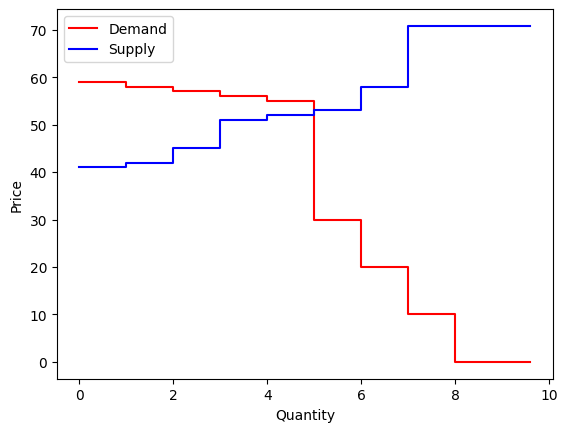

In [7]:
bm.plot()